In [10]:
import igraph as ig
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Connectivity analysis

_Question:_ Does connectivity increase over time within SureChemBL? 

_Hypothesis:_ patents become more connective over time, thereby using more of the same chemical space over time

## Bipartite stats

Use basic statistics (number of nodes & edges of both cpds & patents) from bipartite network analysis to test percent connectivity

In [11]:
df = pd.read_csv("Data/Graphs/bipartite_sizes.csv")
print(df.head())

       date  cpd_nodes  cpd_edges  patent_nodes  patent_edges
0  20150401     869036  484179436         41857     182454199
1  20150701     951080  527550160         47526     231670792
2  20151001    1030925  613582529         47152     230089433
3  20160101    1047732  598757891         52121     289018241
4  20160401     991621  550943030         50111     274711475


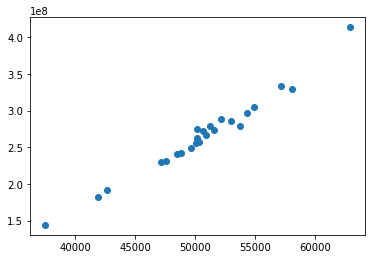

In [13]:
#Does patent nodes scale with patent edges?
plt.scatter(x=df["patent_nodes"], y=df["patent_edges"])

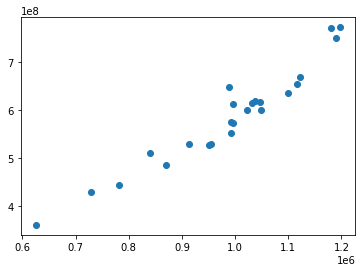

In [14]:
#How about compounds?
plt.scatter(x=df["cpd_nodes"], y=df["cpd_edges"])

In [6]:
#Test graph analysis
G = pickle.load(file=open("Data/Graphs/G_20210101.p", "rb"))
print(ig.summary(G))

IGRAPH UN-T 1162328 4555905 -- 
+ attr: date (v), name (v), type (v)
None
